# Tarea Examen 1
### Ejercicio 1

## Jonathan Alexis Urrutia Anguiano 414011025|

In [1]:
from numpy import *
from pylab import *
%matplotlib inline
%run "funciones_a_llamar.ipynb"

Esta vez, tenemos una particula en una caja que rebotará cada vez que choque con la misma. Le ecuación de movimiento es la siguiente, asumiendo que hay un modelo de fricción:
$$
\left(\begin{array}{c}\dot u_1 \\ \dot v_1 \\ \dot u_2\\ \dot v_2\end{array}\right) = \left(\begin{array}{c} u_2 \\ v_2 \\ \frac{1}{m} fric(u_1)\\-g +\frac{1}{m} fric(v_1)\end{array}\right)
$$
Con $u_1 = x,\, u_2 = \dot x, \, v_1 = y\mbox{ y } v_2 = \dot y$

In [2]:
def e_mov(r_v,t,fric=0, g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-g
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]/m
        dvy = -g- fric([r_v[2],r_v[3]])[1]/m
    return array([dx,dy,dvx,dvy])

In [3]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

La caja en donde estará la caja esta compusta de dos planos inclinados con el mismo ángulo de inclinación que se unen en un punto, una longitud total de $5m$ de largo y cuando acaban los planos inlclinados, se eleva hasta $3m$ más sobre ellos. Los angulos de inclinación serán de $\pi/6$ y $\pi/10$ o lo que es lo mismo, $30^\circ$ y $18^\circ$

In [4]:
def plano(x,angulo):
    return -tan(angulo*pi/180.)*x

def techo(x,angulo):
    y = zeros(len(x))
    a = 5*tan(angulo*pi/180.)
    y[:] = a + 3
    return y

def pared(pt, angulo):
    a = 5*tan(angulo*pi/180.)
    y = arange(a,a+3,.01)
    x = zeros(len(y))
    x[:] = pt
    return array([x,y])

def caja(x,angulo):
    ang = angulo
    pt_i = x[0]
    pt_f = x[-1]
    
    p = -plano(abs(x), ang)
    t = techo(x, ang)
    der = pared(pt_i,ang)
    izq = pared(pt_f,ang)
    
    return plot(x,p[:], x,t[:], der[0,:],der[1,:], izq[0,:],izq[1,:], color = 'black',linewidth=5)

Notemos que se utilizó la función plano, la cual se definió en la Tarea 2. Esta función es un plano inclinado dado un ángulo de inclinación. Utilizando estas funciones se puede visualizar la caja de la siguiente manera.

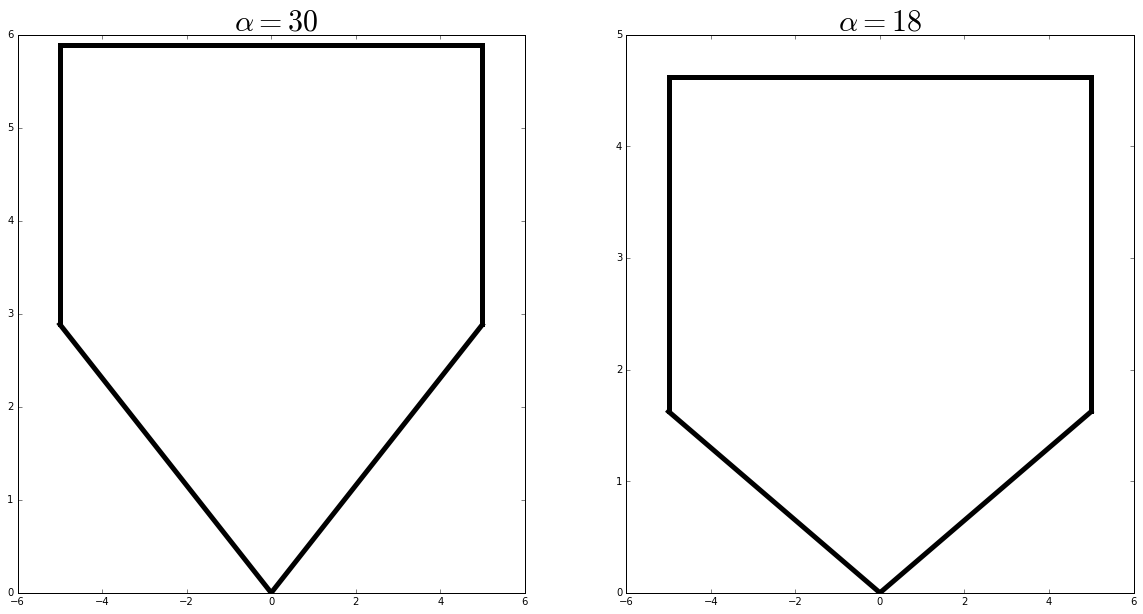

In [5]:
fig, ax = plt.subplots(figsize=(20, 10))

angulos = array([30, 18]) #pi/6, pi/10
equis = arange(-5,5,.01)

subplot(1,2,1)
title(r' $\alpha = %s$' %(str(angulos[0])),fontsize = 30)
caja(equis, angulos[0])

subplot(1,2,2)
title(r'$\alpha = %s$' %(str(angulos[1])),fontsize = 30)
caja(equis, angulos[1])
show()

Para los rebotes, hay que definir los casos para cada una de las cinco fronteras. Siempre son reflexiones en las componentes de la velocidad perpendiculares a la superficies por lo que podemos utilizar la siguiente tranformación lineal para el caso en el que rebote en los planos inclinados. 
$$
\left(\begin{array}{c}x'\\y'\\\dot x'\\\dot y' \end{array}\right) = \left(\begin{array}{c c c c}1 & 0 & 0 & 0\\0& 1& 0 &0 \\0&0& \cos\theta & -\sin\theta\\0&0&\sin\theta & \cos\theta \end{array}\right) \left(\begin{array}{c}x\\y\\\dot x \\ \dot y \end{array}\right) 
$$
Se utilizarará $\theta = \alpha$ si cae en el lado izquierdo o $\theta = -\alpha$. Para el caso del techo o de las paredes no es necesario hacer rotaciones en las velocidades para saber qué componentes son reflejadas.

In [6]:
def rot_vel(ang):
    ang = ang*pi/180.
    return array([1,0,0,0]),array([0,1,0,0]),array([0,0,cos(ang),-sin(ang)]),array([0,0,sin(ang),cos(ang)])

Para el rebote con los planos se utilizará la función de la Tarea dos, la cual al encontrar las raices con  los planos rota las velocidades para conocer las componentes reflejadas (las perpendiculares a las superficies).

In [7]:
def rebote(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]

    while abs(y_izq[1]-plano(y_izq[0],ang))>1e-5:
        if (y_izq[1]-plano(y_izq[0],ang))*(y_med[1]-plano(y_med[0],ang))<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rot_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

La altura del techo depende del ángulo de inclinación de los planos. Se fija el valor que tiene el techo para cáda ángulo es utilizado el mismo algoritmo que en la función de arriba. En este caso lo único que se refleja es la componente $y$ por lo que no es necesario hacer ninguna rotación.

In [8]:
def rebote_techo(r_v_i,mi_dt,ang,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    tope_y = 3 + 5*tan(angulo*pi/180.)

    while abs(y_izq[1]-tope_y)>1e-5:
        if (y_izq[1]-tope_y)*(y_med[1]-tope_y)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = dot(rot_vel(ang),y_izq)
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

El último rebote a definir es el de las paredes. Como este valor esta fijo y se encuntre en $\pm 5$, sólo es necesario saber en qué región se está. Se toma el signo del último valor de 5 y así sabermos qué punto es el que no debe pasar. En este caso la componente en $x$ es la reflejada.

In [9]:
def rebote_pared(r_v_i,mi_dt,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]
    pared = sign(y_izq[0])*5

    while abs(y_izq[0]-pared)>1e-5:
        if (y_izq[0]-pared)*(y_med[0]-pared)<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
        pared = sign(y_izq[0])*5
    y_izq = array([y_izq[0],y_izq[1],-y_izq[2],y_izq[3]])
    return y_izq

Lo único que resta es saber cuándo cada condición es aplicada. 
Si $x<0$ y cruza el plano inclinado se entra a la función rebote con un ángulo de incinación de $\alpha$. Si $x>0$ y curza el plano, entonces el ángulo a considerar es $-\alpha$. Si $5 < |x|$ entonces entra rebote_pared. Si la altura es mayor que el techo entra en rebote_techo.

In [10]:
def datos_graf(cond_ini, ang, modelo_fric=0,pts=100, dt=0.1):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    tope_y = 3 + 5*tan(angulo*pi/180.)
    
    for i in range(N-1):
        t,sol_dt = rk4(e_mov,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][0]<=0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][0] > 0 and sol_dt[-1,:][1]-plano(sol_dt[-1,:][0], -ang) < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt,-ang)    
            trayectoria[i+1,:] = y_izq
        elif sol_dt[-1,:][1] >= tope_y:
            y_izq = rebote_techo(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        elif 5 <= abs(sol_dt[-1,:][0]):
            y_izq = rebote_pared(trayectoria[i,:],mi_dt,0)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    return trayectoria

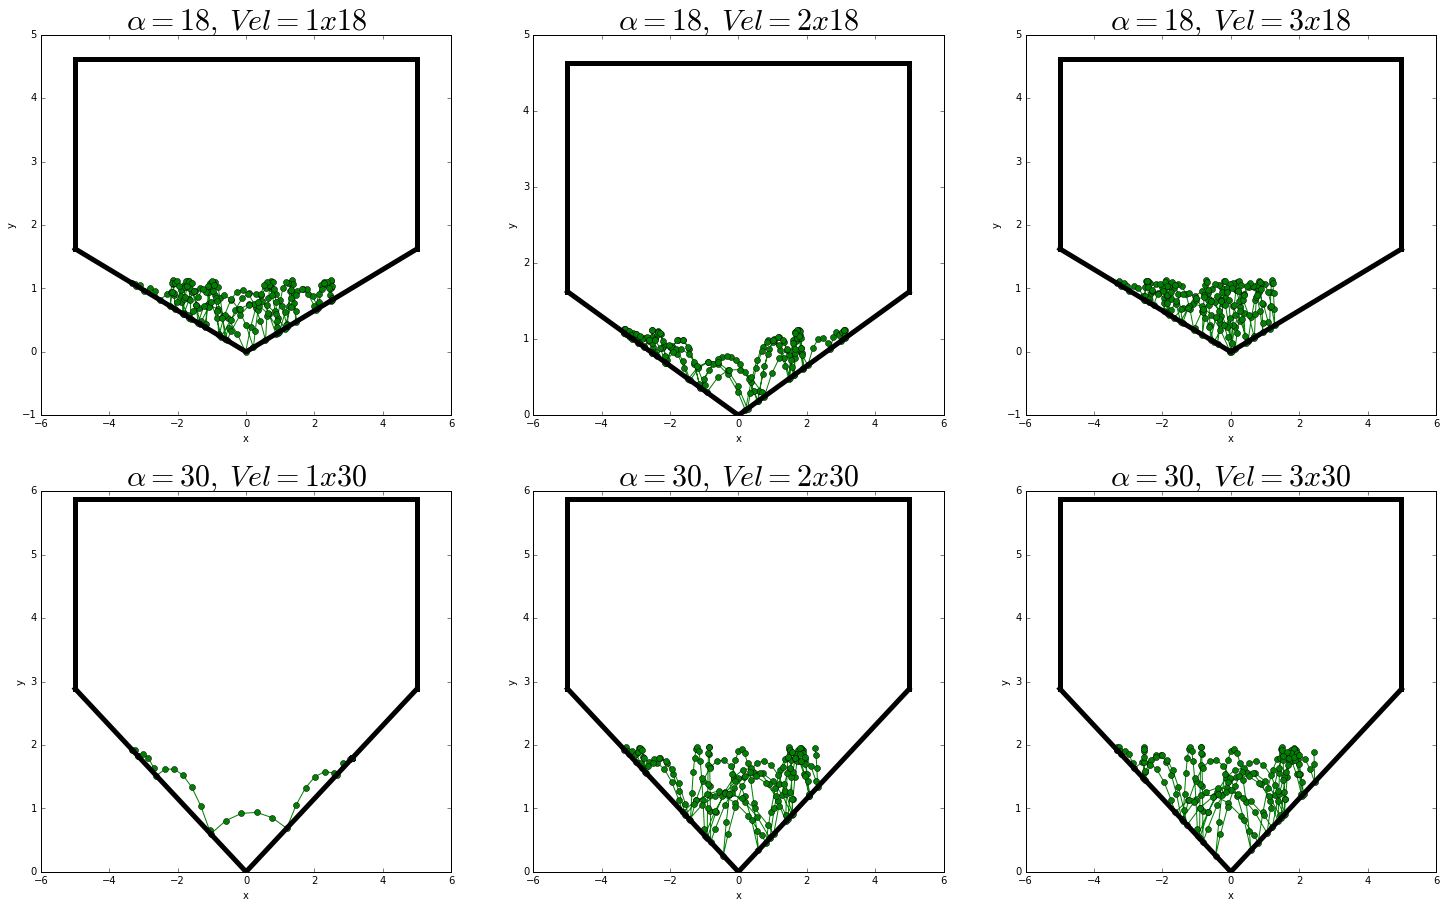

In [11]:
angulos = [18,30]
multi = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(j*angulo*pi/180), sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,200)
        
        subplot(2,3, n)
        title(r'$\alpha = %s\; Vel= %s$' %(str(angulos[i])+',',str(j)+'x'+str(angulos[i])),fontsize = 30),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
        plot(inicio[0],inicio[1],'*')
        caja(equis, angulo)
        n +=1
show()

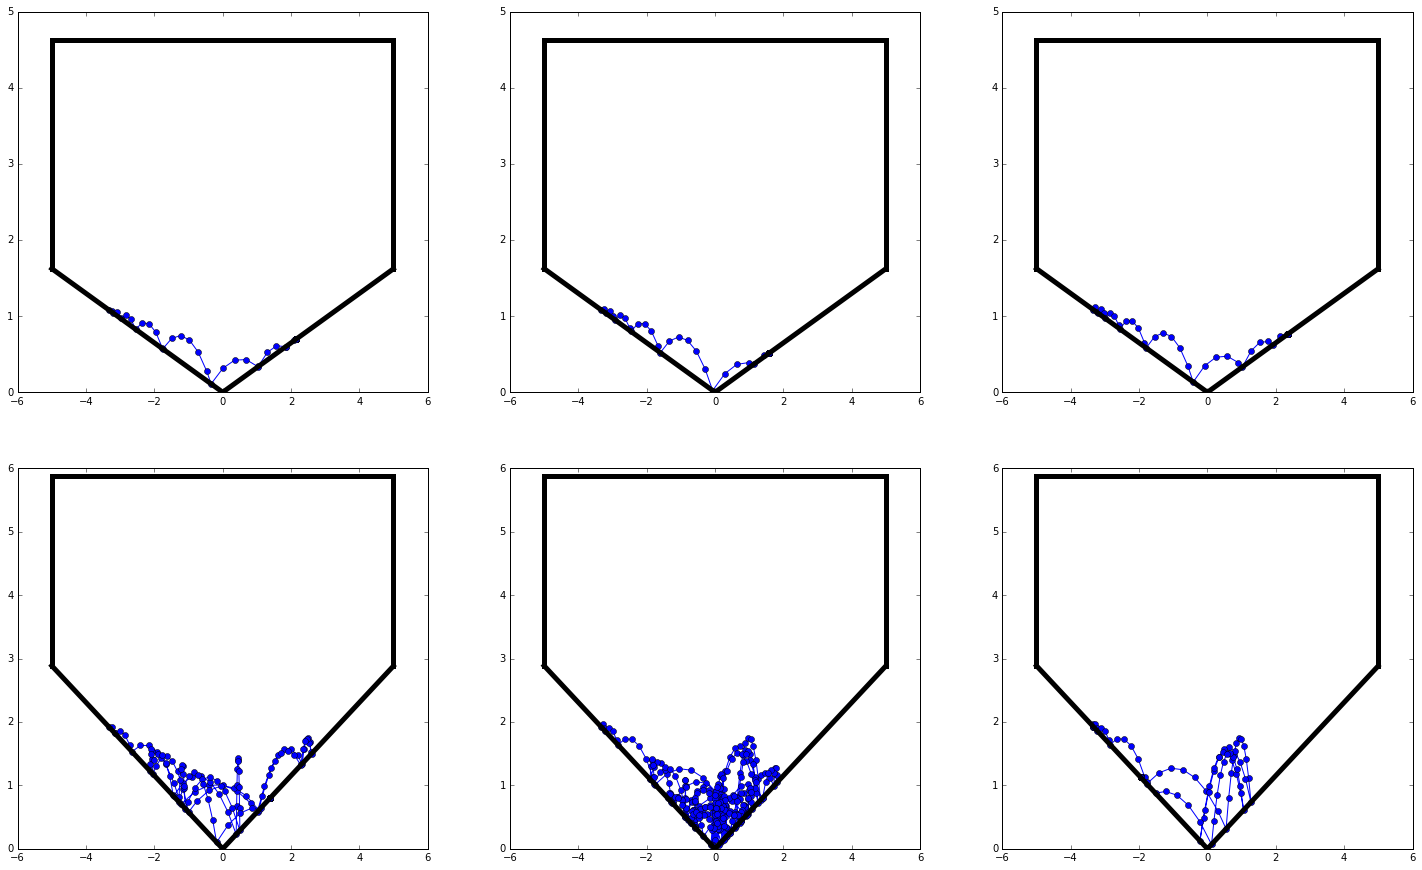

In [20]:
angulos = [18,30]
multi = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, cos(j*angulo*pi/180), sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,fric_v,300)
        
        subplot(2,3, n),  xlim([-5.5,5.5]), ylim([0,6.1])
        title(r'$\alpha = %s\; V_0= (\cos(%s \alpha),sin(%s \alpha))$' %(str(angulos[i])+',',str(j),str(j)),fontsize = 25),xlabel('x'),ylabel('y')
        plot(trayectoria[:,0],trayectoria[:,1],'o-')
        plot(inicio[0],inicio[1],'*')
        caja(equis, angulo)
        n +=1
show()

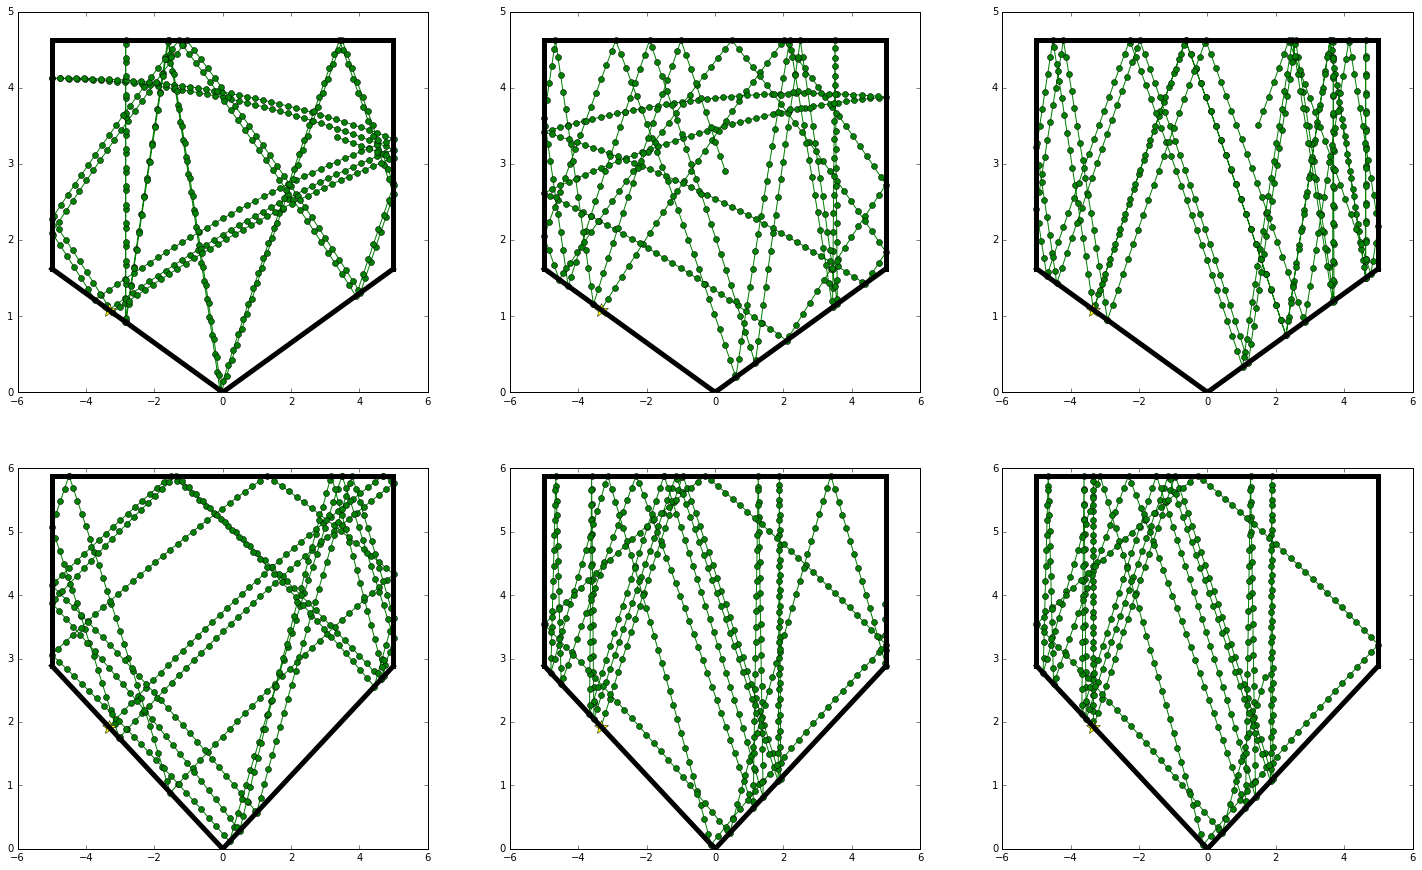

In [69]:
angulos = [18,30]
multi = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(j*angulo*pi/180), 25*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,500,.01)
        
        subplot(2,3, n)
        plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
        plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
        caja(equis, angulo)
        n +=1
show()

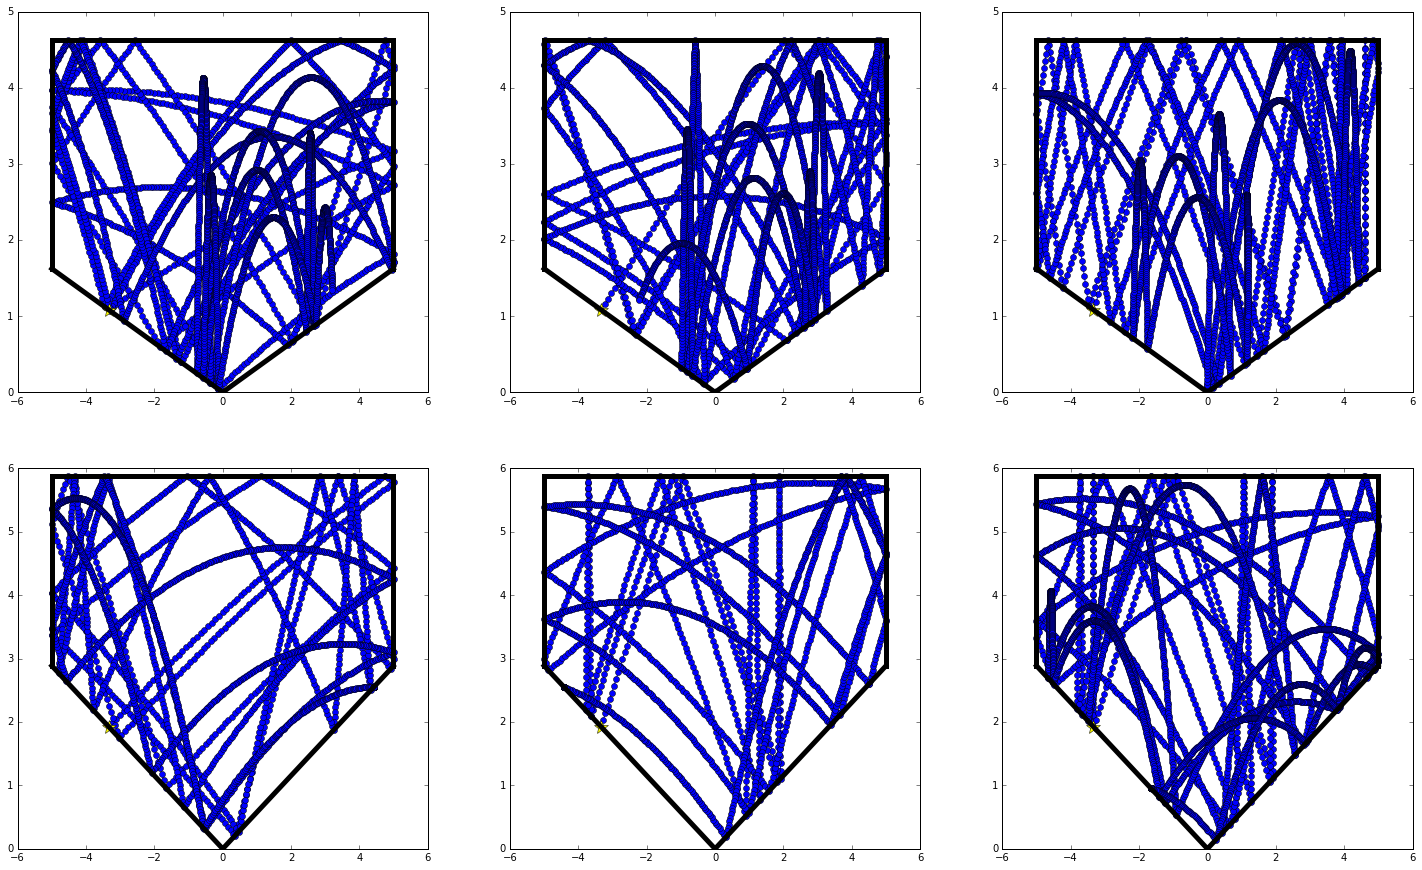

In [34]:
fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(j*angulo*pi/180), 25*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,fric_v,5000,.01/2)
        
        subplot(2,3, n)
        plot(trayectoria[:,0],trayectoria[:,1],'o-')
        plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
        caja(equis, angulo)
        n +=1
show()

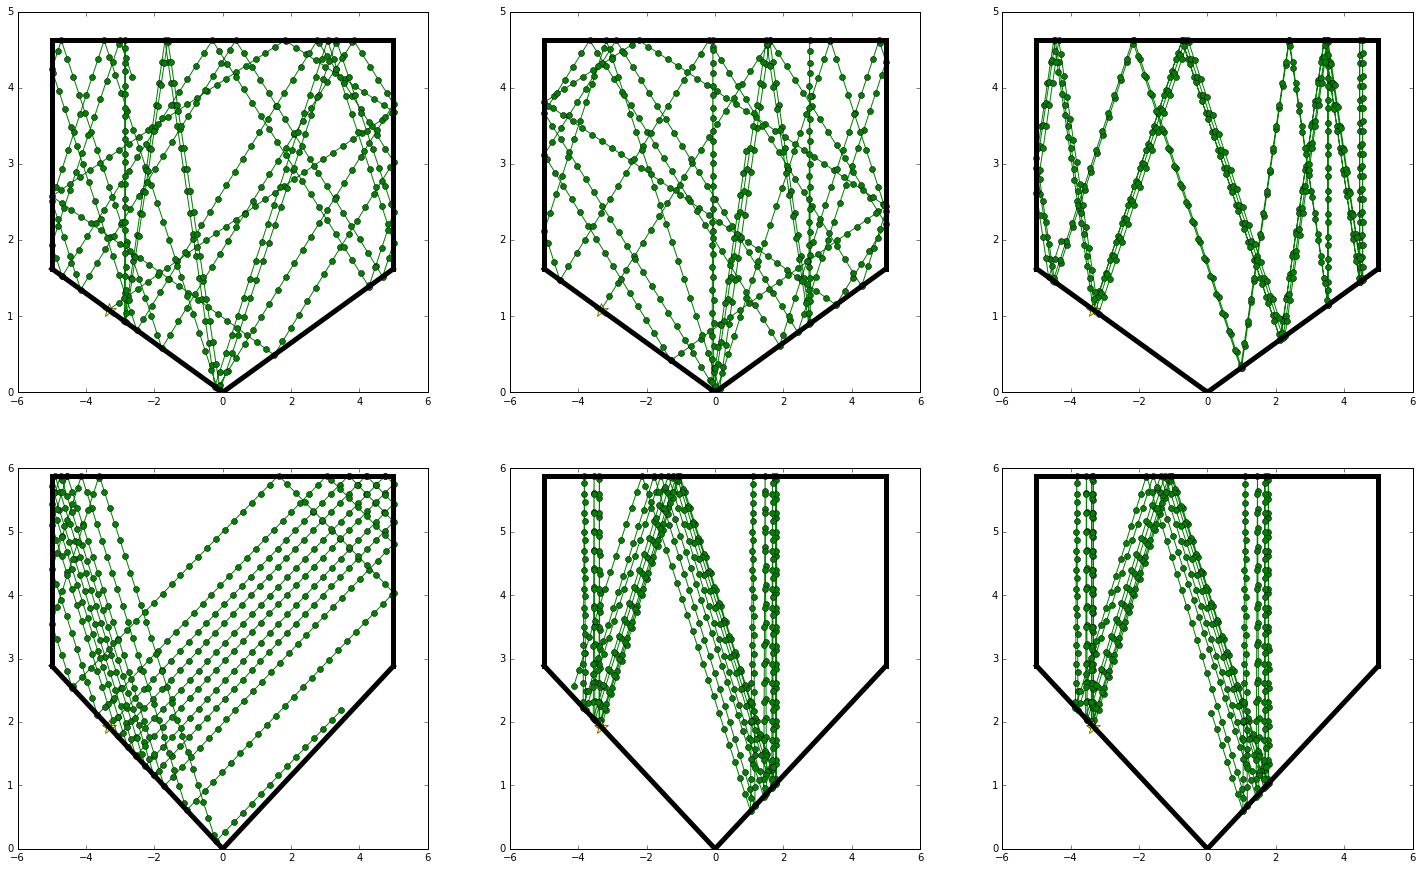

In [46]:
angulos = [18,30]
multi = [1,2,3]

fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 60*cos(j*angulo*pi/180), 60*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,0,500,.1/20)
        
        subplot(2,3, n)
        plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
        plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
        caja(equis, angulo)
        n +=1
show()

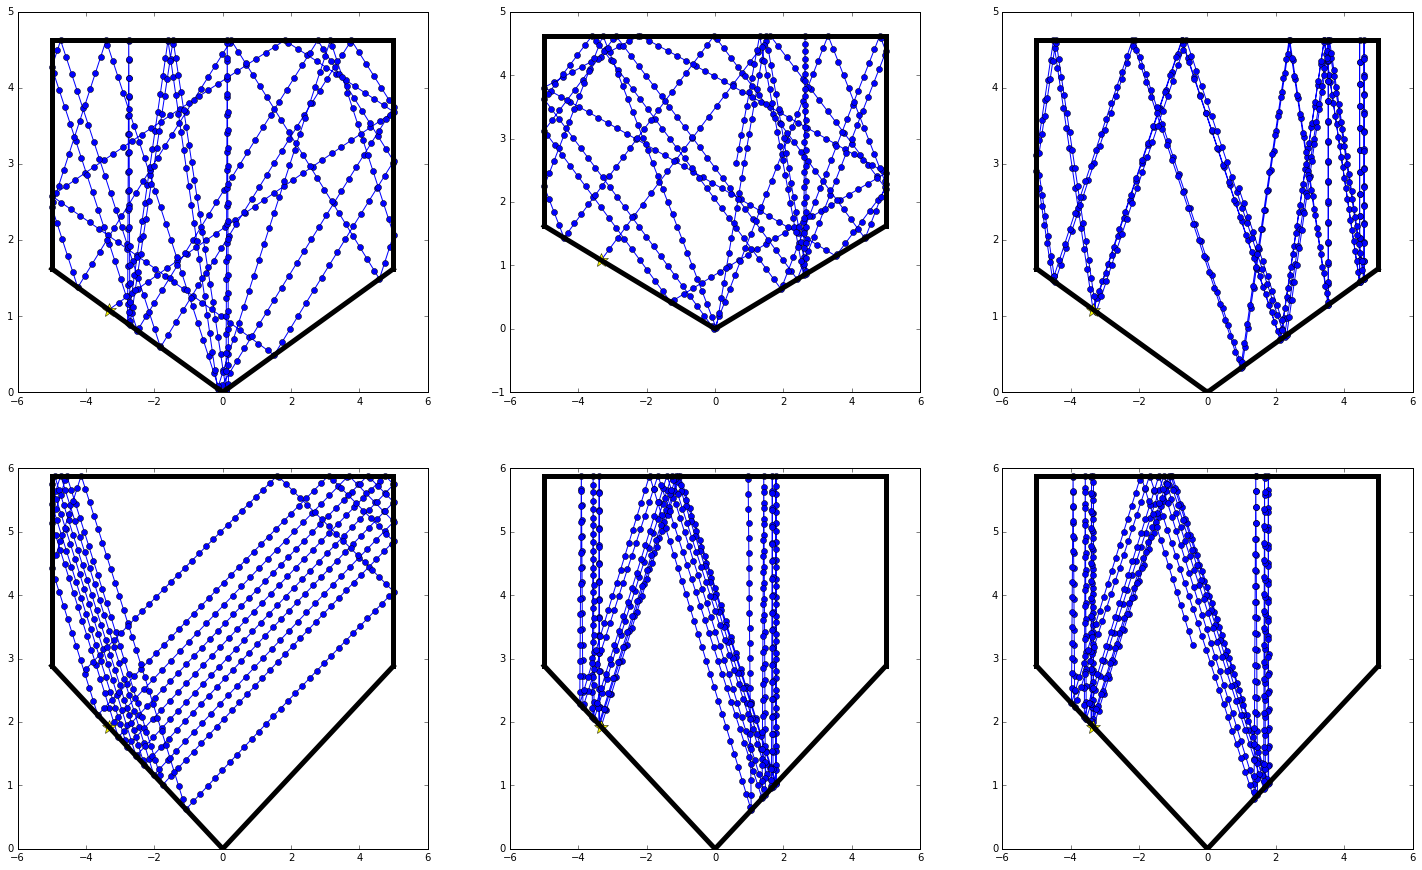

In [54]:
fig, ax = plt.subplots(figsize=(25,15 ))

n = 1
for i in xrange(len(angulos)):
    angulo = angulos[i]

    for j in multi:
        inicio = [-10./3,10.*tan(angulo*pi/180)/3, 60*cos(j*angulo*pi/180), 60*sin(j*angulo*pi/180)]
        trayectoria = datos_graf(inicio,angulo,fric_v,500,.1/20)
        
        subplot(2,3, n)
        plot(trayectoria[:,0],trayectoria[:,1],'o-')
        plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
        caja(equis, angulo)
        n +=1
show()

Ahora vamos a considerar el caso en el que la velocidad tiene norma de 25 y es lanzado de forma vertical y otro en el que se lanza con un ángulo igual a la pendiente del plano. Además se verán los espacios faces de las soluciones.

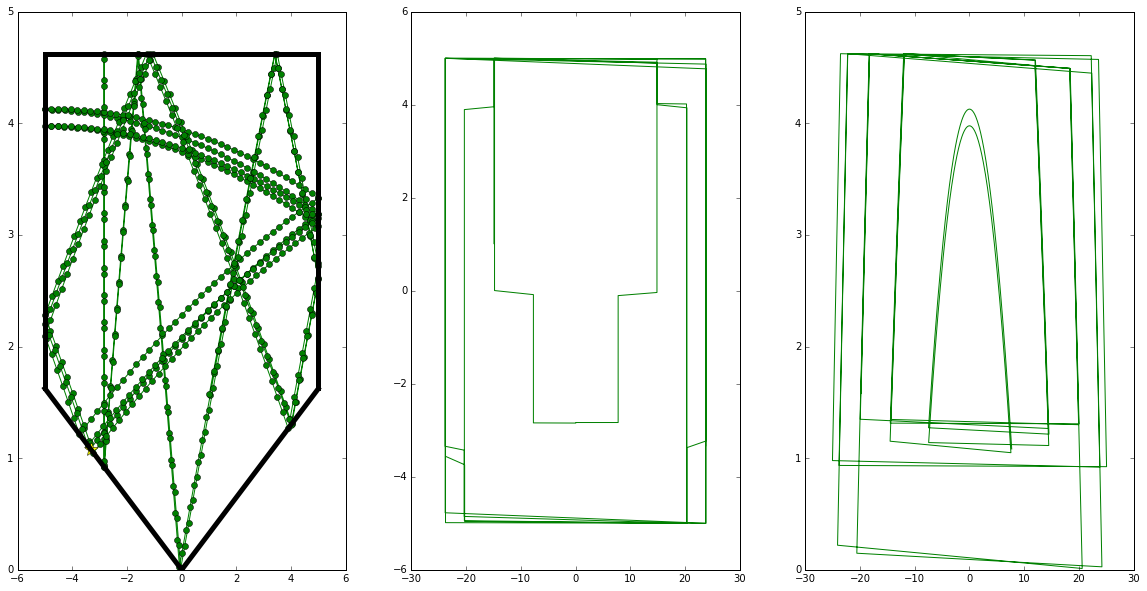

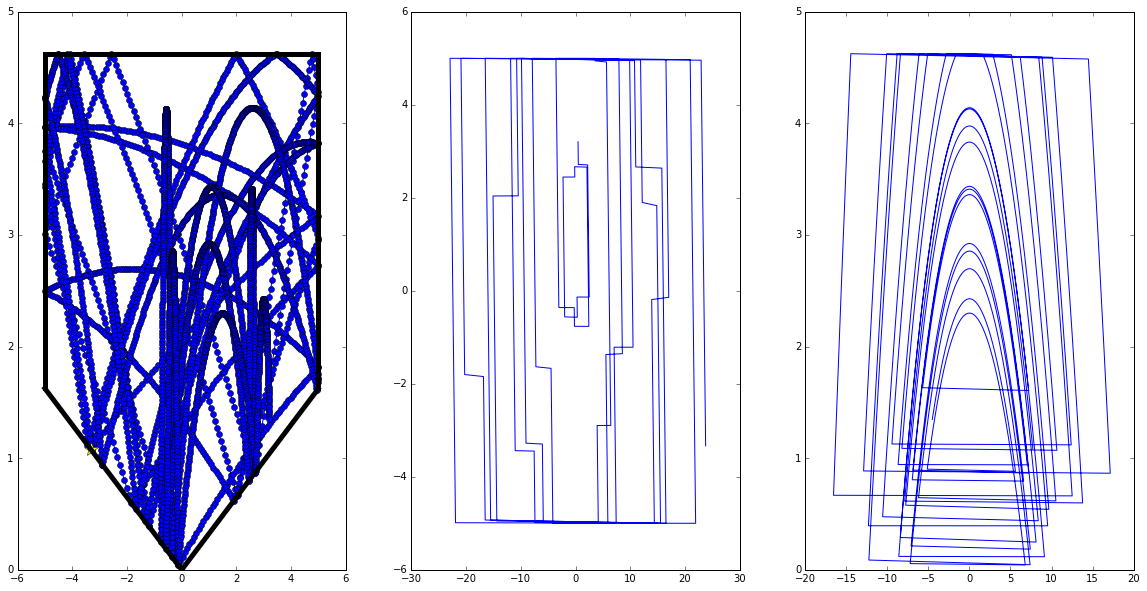

In [72]:
fig, ax = plt.subplots(figsize=(20,10 ))

angulo = 18
inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(angulo*pi/180), 25*sin(angulo*pi/180)]
trayectoria = datos_graf(inicio,angulo,0,700,.01)


subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'green')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green')

show()

fig, ax = plt.subplots(figsize=(20,10 ))
trayectoria = datos_graf(inicio,angulo,fric_v,5000,.01/2)

subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-')

show()

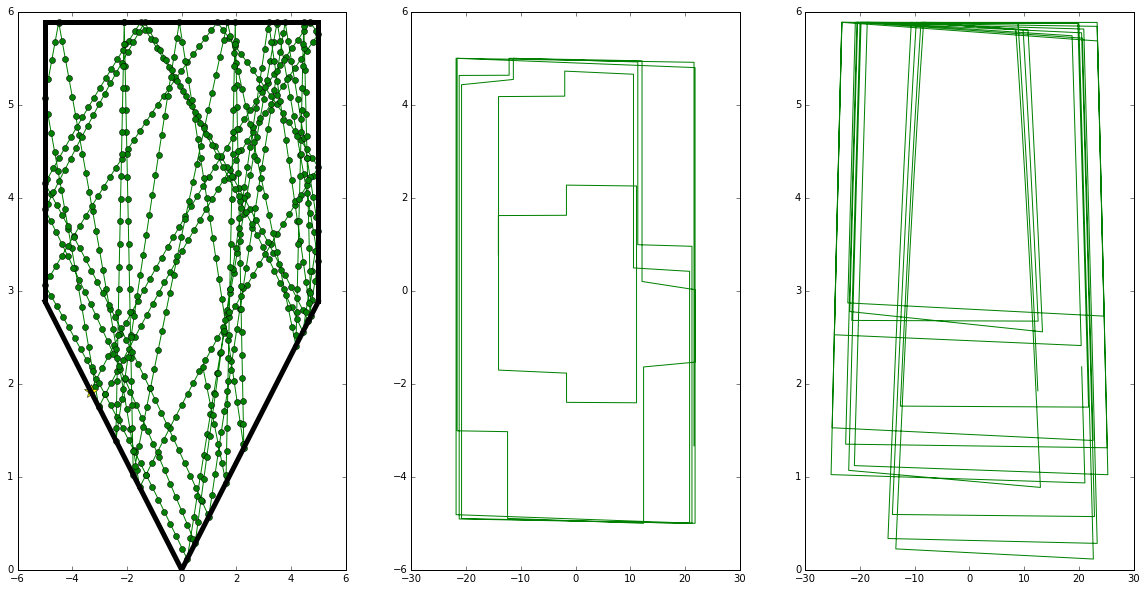

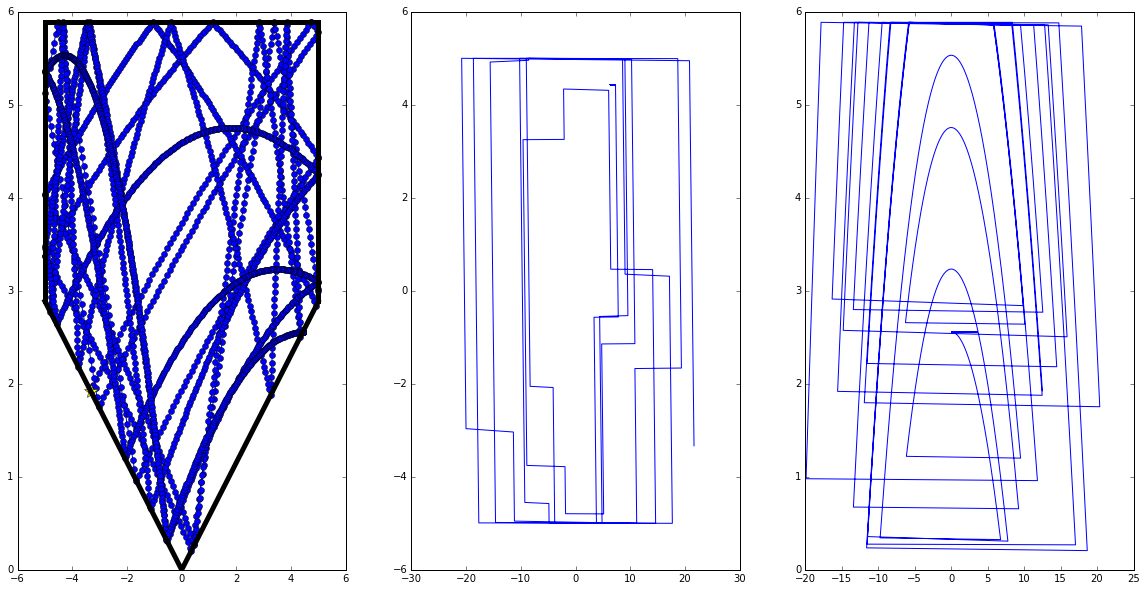

In [73]:
fig, ax = plt.subplots(figsize=(20,10 ))

angulo = 30
inicio = [-10./3,10.*tan(angulo*pi/180)/3, 25*cos(angulo*pi/180), 25*sin(angulo*pi/180)]
trayectoria = datos_graf(inicio,angulo,0,700,.01)


subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'green')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green')

show()

fig, ax = plt.subplots(figsize=(20,10 ))
trayectoria = datos_graf(inicio,angulo,fric_v,5000,.01/2)

subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-')

show()

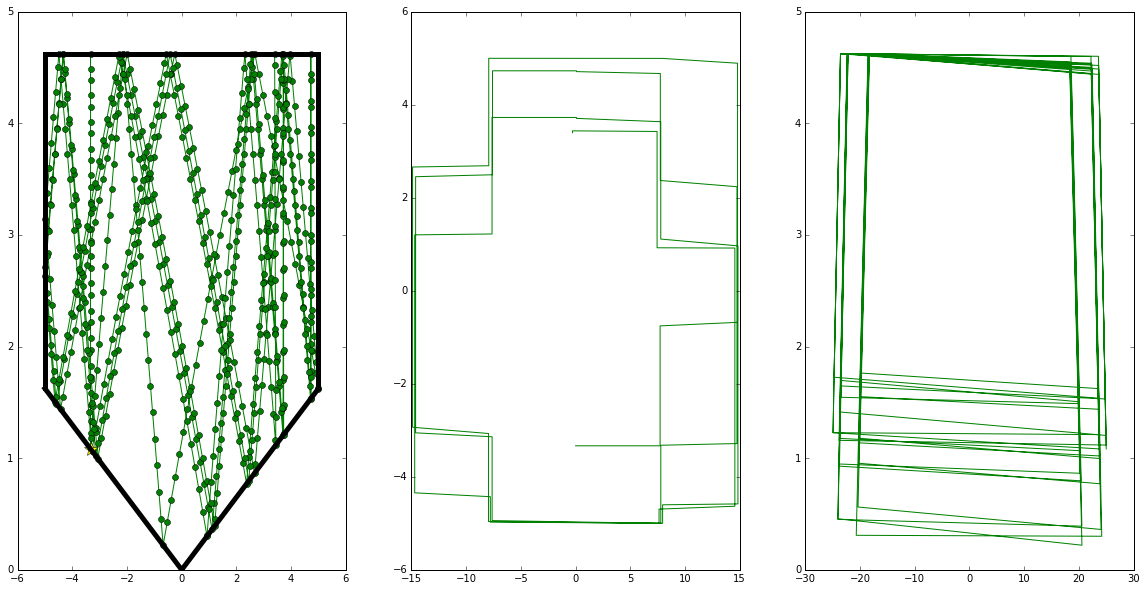

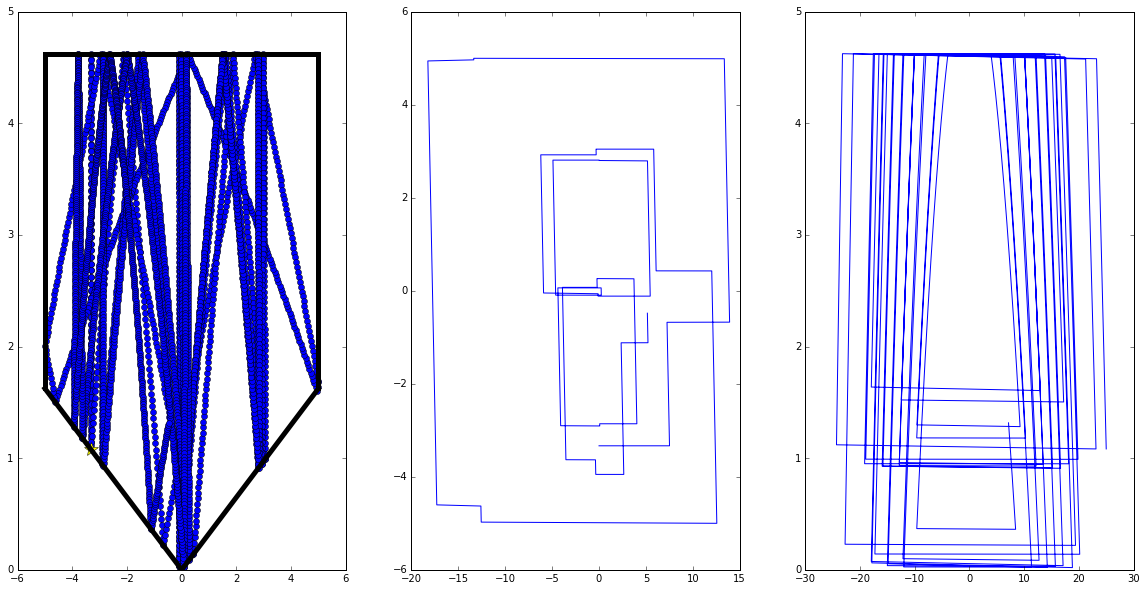

In [83]:
fig, ax = plt.subplots(figsize=(20,10 ))

angulo = 18
inicio = [-10./3,10.*tan(angulo*pi/180)/3, 0, 25]
trayectoria = datos_graf(inicio,angulo,0,700,.01)


subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'green')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green')

show()

fig, ax = plt.subplots(figsize=(20,10 ))
trayectoria = datos_graf(inicio,angulo,fric_v,5000,.01/4)

subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-')

show()

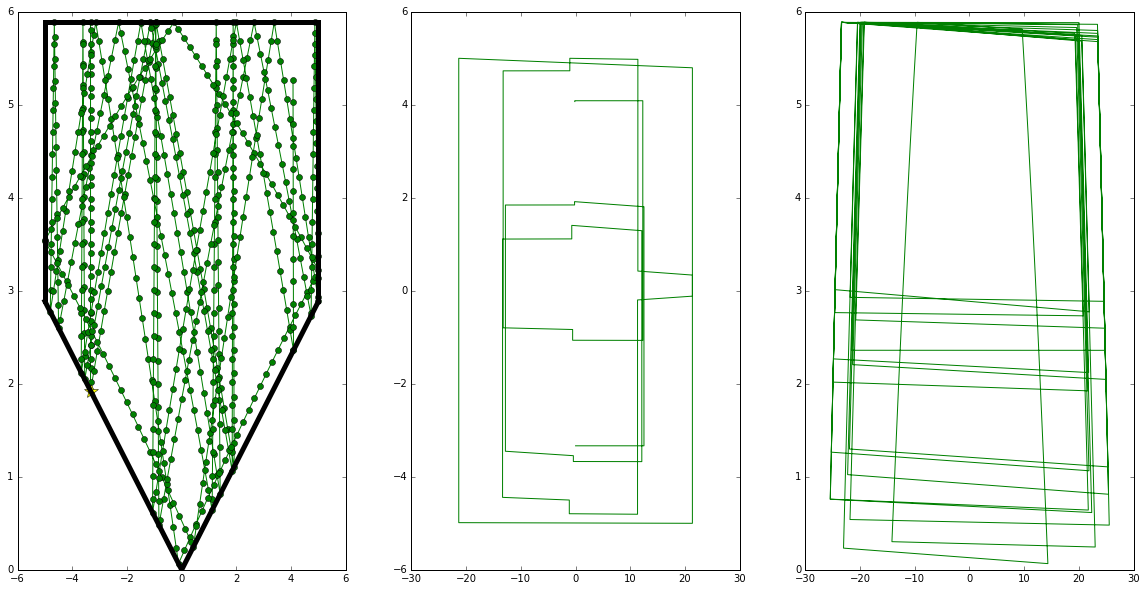

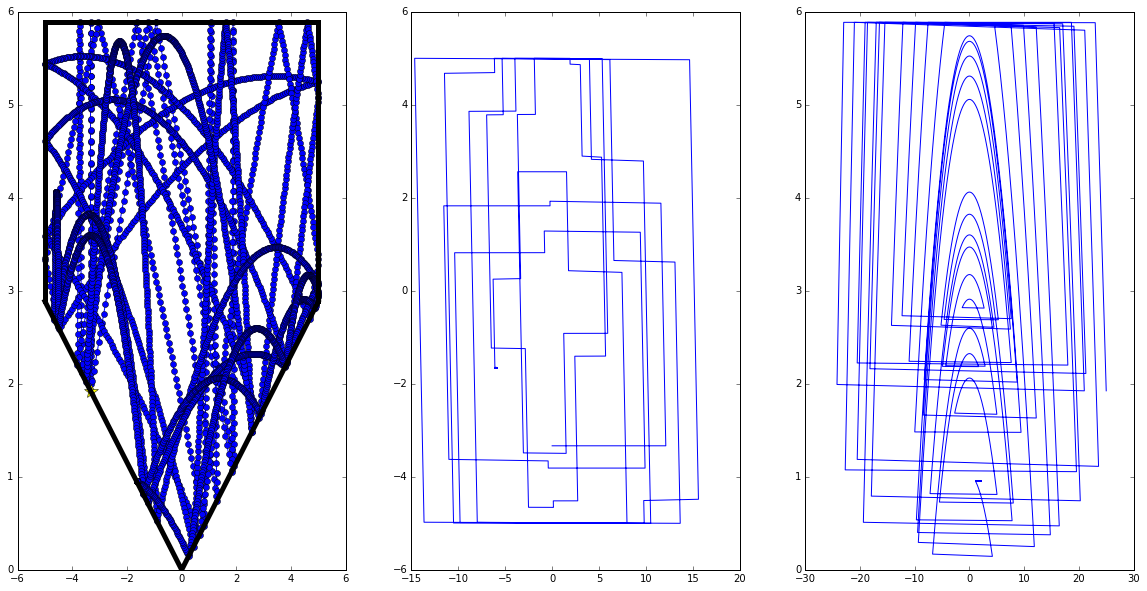

In [78]:
fig, ax = plt.subplots(figsize=(20,10 ))

angulo = 30
inicio = [-10./3,10.*tan(angulo*pi/180)/3, 0, 25]
trayectoria = datos_graf(inicio,angulo,0,700,.01)


subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-',color = 'green')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-',color = 'green')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-',color = 'green')

show()

fig, ax = plt.subplots(figsize=(20,10 ))
trayectoria = datos_graf(inicio,angulo,fric_v,5000,.01/2)

subplot(1,3, 1)
plot(trayectoria[:,0],trayectoria[:,1],'o-')
plot(inicio[0],inicio[1],'*',color='yellow',markersize=15)
caja(equis, angulo)

subplot(1,3, 2)
plot(trayectoria[:,2],trayectoria[:,0],'-')

subplot(1,3, 3)
plot(trayectoria[:,3],trayectoria[:,1],'-')

show()